# Predicting Sin and Cos

사실 목표는 그 다음 값을 찾는것이 아니라.. magnitude of 100 을 갖고 있는 vector x 를 받으면 동일한 magnitude의 y를 예측하는 것.. 
즉 그다음 하나하나를 예측하는게 아니라.. 한방에 예측하는 모델

In [1]:
%pylab inline
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Data

x: (400, 300, 1)
y: (400, 300, 1)


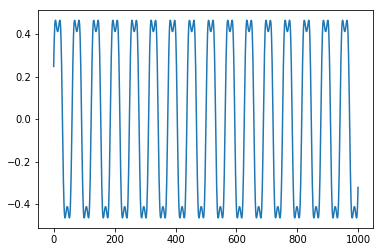

In [69]:
SIZE = 300

data = np.arange(-50, 50, 0.1)
data = np.sin(data)
data = np.cos(data)* np.tanh(data)

def make_x_y(data, size=500):
    N = data.shape[0]
    
    data_x = np.zeros((N-size*2, size))
    data_y = np.zeros((N-size*2, size))
    for i, idx in enumerate(range(0, N-size*2)):
        x = data[idx: idx+size]
        y = data[idx+size: idx+size*2]
        
        data_x[idx, :x.shape[0]] = x
        data_y[idx, :y.shape[0]] = y
        
    data_x = np.asarray(data_x)
    data_y = np.asarray(data_y)
    
    data_x = data_x.reshape(-1, size, 1)
    data_y = data_y.reshape(-1, size, 1)
    return data_x, data_y
x, y = make_x_y(data, size=SIZE)


print('x:', x.shape)
print('y:', y.shape)

plot(data)

### Visualize training data 

x값과 y값을 한번에 합쳐서 보여줍니다.<br> 
대충 중간에 선이 있다고 생각하면 됩니다. 왼쪽은 x값 오른쪽은 y값


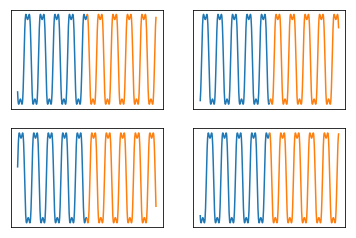

In [71]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            r = np.random.randint(data_x.shape[0])
            sample_x = data_x[r]
            sample_y = data_y[r]
            
            
            sample_x = sample_x.reshape(sample_x.shape[0])
            sample_y = sample_y.reshape(sample_y.shape[0])
            tick_x = range(0, SIZE)
            tick_y = range(SIZE, SIZE*2)
            
            sp.plot(tick_x, sample_x)
            sp.plot(tick_y, sample_y)

visualize(x, y)

## Model

In [50]:
model = Sequential(name='lstm')
model.add(LSTM(batch_input_shape=(None, None, 1), output_dim=50, return_sequences=True))
model.add(Dense(output_dim=10, name='fully_connected_layer01'))
model.add(Dense(output_dim=1, name='fully_connected_layer02'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, verbose=2)

Epoch 1/10
4s - loss: 0.0805
Epoch 2/10
3s - loss: 0.0291
Epoch 3/10
3s - loss: 0.0209
Epoch 4/10
3s - loss: 0.0179
Epoch 5/10
3s - loss: 0.0161
Epoch 6/10
3s - loss: 0.0147
Epoch 7/10
3s - loss: 0.0135
Epoch 8/10
3s - loss: 0.0124
Epoch 9/10
3s - loss: 0.0115
Epoch 10/10
3s - loss: 0.0107


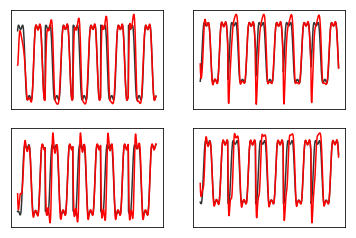

In [59]:
def visualize_prediction(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
        
            idx = np.random.randint(data_x.shape[0])
            y_pred = model.predict(data_x[idx: idx+1])
            
            _y = data_y[idx].reshape(data_y[idx].shape[0])
            _p = y_pred[0].reshape(y_pred[0].shape[0])
            
            sp.plot(_y, color='#333333')
            sp.plot(_p, color='red')

test_x = x.reshape(-1).reshape(-1, 500, 1)
test_y = y.reshape(-1).reshape(-1, 500, 1)


visualize_prediction(test_x, test_y)

